In [1]:
## Example from: https://www.tensorflow.org/tutorials/text/text_classification_rnn

In [2]:
pip install -q tensorflow_datasets

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [3]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
config = tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [4]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [5]:
## Download the imdb review dataset. This dataset has a binary label
## for each text input. Label beign the move is good or bad (positive or negative)
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
## Split the dataset into train and test set
train_dataset, test_dataset = dataset['train'], dataset['test']
## Check the data types of inputs and output
train_dataset.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [6]:
## view one input output pair
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


In [7]:
len(train_dataset)
## Buffer size should be equal or greater than the size of train dataset for randomly suffling
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [8]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [9]:
dataset = tf.data.Dataset.range(3)
dataset = dataset.shuffle(3, reshuffle_each_iteration=True)
dataset = dataset.repeat(2)
for eg in dataset:
    print(eg)

tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)


In [10]:
## Take one batch and view first 3 input text and output labels
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b"This was excellent. Touching, action-packed, and perfect for Kurt Russel. I loved this movie, it deserves more than 5.3 or so stars. This movie is the story of an obsolete soldier who learns there is more to life than soldiering, and people who learn that there is a time for fighting, a need to defend. I cried, laughed and mostly sat in awe of this story. Good writing job for an action flick, and the plot was appropriate and fairly solid. The ending wasn't twisty, but it was still excellent. If you like escape from New York, or rooting for the underdog, this movie is for you. Not an undue amount of gore or violence, it was not difficult to watch in that respect. Something for everyone."
 b"I expected alot from this movie. Kinda like Lee as a Naustradamous like caracter but instead all I got was a waste of time and a boring movie. I can't even explain this movie. It had wooden acting, terrible script from pieces from the Bible like hurricanes, tidal waves and earthquakes. But

In [11]:
## Vocabulary size defines the number of unique words we must keep for encoding data through tokenization
## any word that is out of the vocabulary will be annotated as a UKN
VOCAB_SIZE=1000
## The TextVectorization preprocessor converts the sentences into tokens
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [12]:
## view the first 20 words of the vocabulary
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [13]:
## view the tokens of the first 3 examples of the 1st batch
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 11,  14, 312, ...,   0,   0,   0],
       [ 10, 855,   1, ...,   0,   0,   0],
       [ 11,  18,  44, ...,   0,   0,   0]])

In [14]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b"This was excellent. Touching, action-packed, and perfect for Kurt Russel. I loved this movie, it deserves more than 5.3 or so stars. This movie is the story of an obsolete soldier who learns there is more to life than soldiering, and people who learn that there is a time for fighting, a need to defend. I cried, laughed and mostly sat in awe of this story. Good writing job for an action flick, and the plot was appropriate and fairly solid. The ending wasn't twisty, but it was still excellent. If you like escape from New York, or rooting for the underdog, this movie is for you. Not an undue amount of gore or violence, it was not difficult to watch in that respect. Something for everyone."
Round-trip:  this was excellent [UNK] [UNK] and perfect for [UNK] [UNK] i loved this movie it deserves more than [UNK] or so stars this movie is the story of an [UNK] [UNK] who [UNK] there is more to life than [UNK] and people who learn that there is a time for fighting a need to [UNK] i [U

In [15]:
## The sentiment classification model architecture:
model = tf.keras.Sequential([
    encoder, ## Tokenisation layer that converts a batch of input text to tokens with int values
    tf.keras.layers.Embedding( ## A trainable layer that learns to embbed the tokens to a real value distribution
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [16]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [22]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])
print(model.layers[1].output_shape)

[0.0191545]
(None, None, 64)


In [23]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [24]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset, 
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 20s 51ms/step - loss: 0.6432 - accuracy: 0.5747 - val_loss: 0.5174 - val_accuracy: 0.7141
Epoch 2/10
391/391 [==============================] - 19s 49ms/step - loss: 0.3939 - accuracy: 0.8207 - val_loss: 0.3634 - val_accuracy: 0.8260
Epoch 3/10
391/391 [==============================] - 19s 48ms/step - loss: 0.3354 - accuracy: 0.8512 - val_loss: 0.3336 - val_accuracy: 0.8521
Epoch 4/10
391/391 [==============================] - 19s 49ms/step - loss: 0.3179 - accuracy: 0.8625 - val_loss: 0.3276 - val_accuracy: 0.8500
Epoch 5/10
391/391 [==============================] - 19s 48ms/step - loss: 0.3107 - accuracy: 0.8655 - val_loss: 0.3397 - val_accuracy: 0.8333
Epoch 6/10
391/391 [==============================] - 19s 48ms/step - loss: 0.3068 - accuracy: 0.8674 - val_loss: 0.3208 - val_accuracy: 0.8568
Epoch 7/10
391/391 [==============================] - 19s 48ms/step - loss: 0.3048 - accuracy: 0.8682 - val_loss: 0.3300 - val_accuracy:

In [25]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

391/391 [==============================] - 8s 21ms/step - loss: 0.3219 - accuracy: 0.8551
Test Loss: 0.32191672921180725
Test Accuracy: 0.8551200032234192


(0.0, 0.6605073943734169)

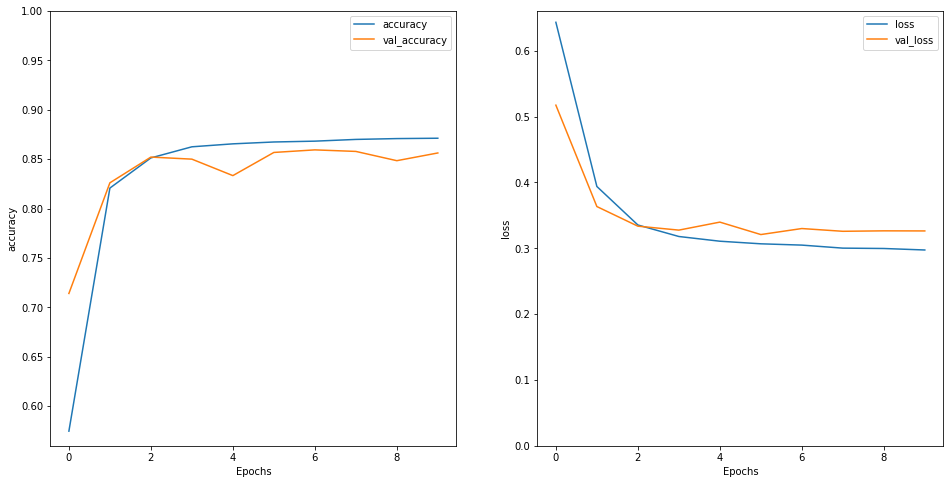

In [26]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(history, 'accuracy')
plt.ylim(None,1)
plt.subplot(1,2,2)
plot_graphs(history, 'loss')
plt.ylim(0,None)

In [28]:
## do a prediction
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
predictions

array([[1.0471424]], dtype=float32)